In [1]:
from google.colab import drive, files
drive.mount('/content/drive/')
path = "/content/drive/My Drive/"
training_data_dir = path + "data/breast_cancer/train/" # 10 000 * 2
#validation_data_dir = path + "data/validation" # 2 500 * 2
test_data_dir = path + "data/breast_cancer/test/" # 12 500

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import sys
import os
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# define location of dataset
#folder = 'train/'
photos, labels = list(), list()
# enumerate files in the directory
for file in listdir(training_data_dir):
	# determine class
	output = 0.0
	if file.endswith('class1.png'):
		output = 1.0
	# load image
	photo = load_img(training_data_dir + file, target_size=(200, 200))
	# convert to numpy array
	photo = img_to_array(photo)
	# store
	photos.append(photo)
	labels.append(output)
# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
save('breast_cancer_photos.npy', photos)
save('breast_cancer_labels.npy', labels)

(2720, 200, 200, 3) (2720,)


In [4]:
from numpy import load
photos = load('breast_cancer_photos.npy')
labels = load('breast_cancer_labels.npy')
print(photos.shape, labels.shape)

(2720, 200, 200, 3) (2720,)


In [0]:
from os import makedirs

# create directories
dataset_home = path + 'data/breast_cancer/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['malade/', 'sain/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

In [0]:
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = training_data_dir
for file in listdir(src_directory):
	src = src_directory + file
	dst_dir = training_data_dir
	if random() < val_ratio:
		dst_dir = test_data_dir
	if file.endswith('class1.png'):
		dst = dst_dir + 'malade/'  + file
		copyfile(src, dst)
	elif file.endswith('class0.png'):
		dst = dst_dir + 'sain/'  + file
		copyfile(src, dst)

In [0]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [0]:
model = define_model()

In [0]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [10]:
# prepare iterators
train_it = datagen.flow_from_directory(training_data_dir,
	class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = datagen.flow_from_directory(test_data_dir,
	class_mode='binary', batch_size=64, target_size=(200, 200))

Found 2039 images belonging to 2 classes.
Found 671 images belonging to 2 classes.


In [0]:
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)

In [12]:
# evaluate model
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

> 91.505


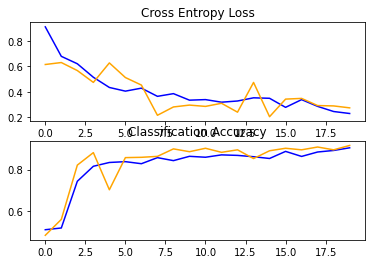

In [15]:
# plot diagnostic learning curves

	# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
filename = sys.argv[0].split('/')[-1]
pyplot.savefig(filename + '_plot.png')
#pyplot.close()
pyplot.show()